In [55]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from colorama import Back, Fore, Style
from scipy.stats import rankdata
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.linear_model import (HuberRegressor, LinearRegression,
                                  LogisticRegression)
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler,
                                   PowerTransformer, RobustScaler,
                                   StandardScaler)

warnings.filterwarnings('ignore')

# My Code

In [40]:
# Read csv
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [41]:
# Check if any rows of data are duplicated
t = train.duplicated()
t.unique()

array([False])

In [42]:
def preprocessing(df_train, df_test):
    data = pd.concat([df_train, df_test])
    
    data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
    data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
    data['area'] = data['attribute_2'] * data['attribute_3']
    # data['loading'] = np.log(data['loading'])

    # Select the variables used to generate null value of measurement_17 for each product code
    # e.g. for product 'A', NaN values in measurement_17 is filled by a linear combination of (measurement_5, measurement_6, measurement_8)
    full_fill_dict = {
        'A': ['measurement_5','measurement_6','measurement_8'],
        'B': ['measurement_4','measurement_5','measurement_7'],
        'C': ['measurement_5','measurement_7','measurement_8','measurement_9'],
        'D': ['measurement_5','measurement_6','measurement_7','measurement_8'],
        'E': ['measurement_4','measurement_5','measurement_6','measurement_8'],
        'F': ['measurement_4','measurement_5','measurement_6','measurement_7'],
        'G': ['measurement_4','measurement_6','measurement_8','measurement_9'],
        'H': ['measurement_4','measurement_5','measurement_7','measurement_8','measurement_9'],
        'I': ['measurement_3','measurement_7','measurement_8']
    }


    features = [f for f in test.columns if 'measurement' in f] + ['loading']
    for code in data['product_code'].unique(): # ('A', 'B', ..., 'I')
        tmp = data[data['product_code'] == code]
        column = full_fill_dict[code]
        
        # the data used to train the HuberRegressor, so all variables & `measurement_17` should exist <=> drop all NaN values
        tmp_train = tmp[column + ['measurement_17']].dropna(how='any')
        
        # tmp_test = tmp[(all variables in `full_fill_dict[code]` are not NaN) & (the `measurement_17` is NaN in the row of data)]
        tmp_test = tmp[(tmp[column].isnull().sum(axis=1) == 0) & (tmp['measurement_17'].isnull())]
        print(f"code {code} has {len(tmp_test)} samples to fill nan")
        
        
        model = HuberRegressor()
        model.fit(tmp_train[column], tmp_train['measurement_17'])
        # Fill the missing `measurement_17` values by the trained model
        data.loc[(data['product_code'] == code) & (data[column].isnull().sum(axis=1) == 0) & (data['measurement_17'].isnull()), 'measurement_17'] = model.predict(tmp_test[column])
        
        # Other missing values are filled by KNNImputer
        model2 = KNNImputer(n_neighbors=5)
        print(f"KNN imputing code {code}")
        data.loc[(data['product_code'] == code), features] = model2.fit_transform(data.loc[(data['product_code'] == code), features])
    
    data['measurement_avg'] = data[[f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)
    
    # [:df_train.shape[0], :] = rows[0:df_train.shape[0]] = [0, df_train.shape[0])
    # [df_train.shape[0]:, :] = rows[df_train.shape[0]:len(rows)+1] = [df_train.shape[0], len(rows)]
    df_train = data.iloc[:df_train.shape[0], :]
    df_test = data.iloc[df_train.shape[0]:, :]
    
    # woe_encoder = WoEEncoder(variables=['attribute_0'])
    # woe_encoder.fit(df_train, df_train['failure'])
    # df_train = woe_encoder.transform(df_train)
    # df_test = woe_encoder.transform(df_test)
    encoder = LabelEncoder()
    df_train['attribute_0'] = encoder.fit_transform(df_train['attribute_0'])
    df_test['attribute_0'] = encoder.fit_transform(df_test['attribute_0'])
    
    return df_train, df_test

df_train, df_test = preprocessing(train, test)

code A has 386 samples to fill nan
KNN imputing code A
code B has 418 samples to fill nan
KNN imputing code B
code C has 391 samples to fill nan
KNN imputing code C
code D has 398 samples to fill nan
KNN imputing code D
code E has 429 samples to fill nan
KNN imputing code E
code F has 420 samples to fill nan
KNN imputing code F
code G has 373 samples to fill nan
KNN imputing code G
code H has 361 samples to fill nan
KNN imputing code H
code I has 377 samples to fill nan
KNN imputing code I


In [43]:
def _scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler = MaxAbsScaler()
    # scaler = RobustScaler()
    # scaler = PowerTransformer()
    
    scaled_train = scaler.fit_transform(train_data[feats])
    scaled_val = scaler.transform(val_data[feats])
    scaled_test = scaler.transform(test_data[feats])
    
    #back to dataframe
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    
    assert len(train_data) == len(new_train)
    assert len(val_data) == len(new_val)
    assert len(test_data) == len(new_test)
    
    return new_train, new_val, new_test

In [44]:
# Make sure all missing values are filled
df_train = df_train[df_train.failure.notnull()]
df_test = df_test[df_test.failure.isnull()]
print(df_train.shape, df_test.shape)

(26570, 30) (20775, 30)


In [45]:
X = df_train.drop(['failure'], axis=1)
y = df_train.failure # y = df_train['failure']

In [46]:
def save_fig(x_train, importance_list, features):
    importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[features].columns)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = x_train[features].columns
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title(f'LR Clf feature importances')
    plt.tight_layout()
    plt.savefig(f'LR Clf Feature Importance')
    plt.show()

In [47]:
# Find the most significant features
selector = SelectFromModel(estimator=LogisticRegression(), max_features=5).fit(df_train.drop(['failure', 'product_code', 'attribute_1'], axis=1), df_train['product_code'])
print(df_train.drop(['failure', 'product_code', 'attribute_1'], axis=1).columns)
selector.get_support()

Index(['id', 'loading', 'attribute_0', 'attribute_2', 'attribute_3',
       'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3',
       'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7',
       'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11',
       'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15',
       'measurement_16', 'measurement_17', 'm3_missing', 'm5_missing', 'area',
       'measurement_avg'],
      dtype='object')


array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False])

In [48]:
# Not sure why `m5_missing` is not selected from the code above, but it has greater influence than other features
select_features = ['loading', 'measurement_17', 'm5_missing', 'attribute_0']

########################## 0 ##########################
########################## 1 ##########################
########################## 2 ##########################
########################## 3 ##########################
########################## 4 ##########################
Average auc = 0.59096, Average acc = 0.78739
OOF auc = 0.59091, OOF acc = 0.78739
############# End of Classifier #############


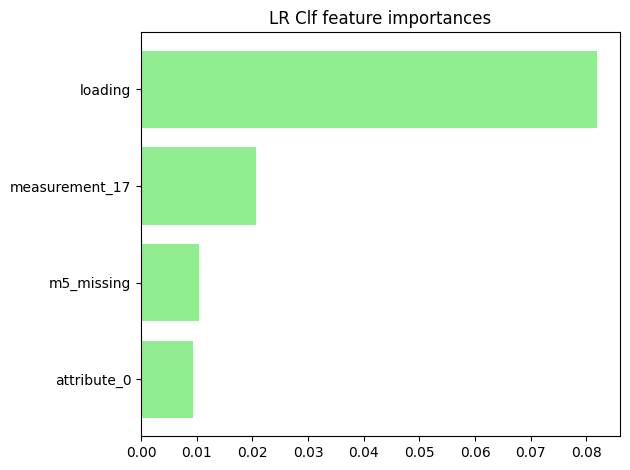

In [49]:
# kf = GroupKFold(n_splits=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
lr_oof_1 = np.zeros(len(train))
lr_oof_2 = np.zeros(len(train))
lr_test = np.zeros(len(test))
lr_auc = 0
lr_acc = 0
importance_list = []
features = select_features
    
# for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y, groups=X['product_code'])):
# Cross-Validation for 4 Logistic Regression Model
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'########################## {fold_idx} ##########################')
    # iloc : indexed_location (by int index ('int'))
    # loc : location (by feature name ('object'))
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_test = df_test.copy()
    
    # Use StandardScaler to standardize the data
    x_train, x_val, x_test = _scale(x_train, x_val, x_test, features)
        
    model = LogisticRegression(max_iter=1000, C=0.0001, dual=False, penalty="l2", solver='newton-cg')
    model.fit(x_train[features], y_train)
        
    # numpy.ravel() : Return a contiguous flattened array.
    importance_list.append(model.coef_.ravel())


    predictions = model.predict_proba(x_val[features])[:, 1]
    lr_auc += roc_auc_score(y_val, predictions) / 5
    
    y_preds = model.predict(x_val[features])
    lr_acc += accuracy_score(y_val, y_preds) / 5
    
    lr_test += model.predict_proba(x_test[features])[:, -1] / 5
    lr_oof_1[val_idx] = predictions
    lr_oof_2[val_idx] = y_preds

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(df_train['failure'], lr_oof_1), 5)}, OOF acc = {round(accuracy_score(df_train['failure'], lr_oof_2), 5)}{Style.RESET_ALL}")
print(f'############# End of Classifier #############')
    
submission['lr0'] = lr_test
save_fig(x_train=x_train, importance_list=importance_list, features=features)
    

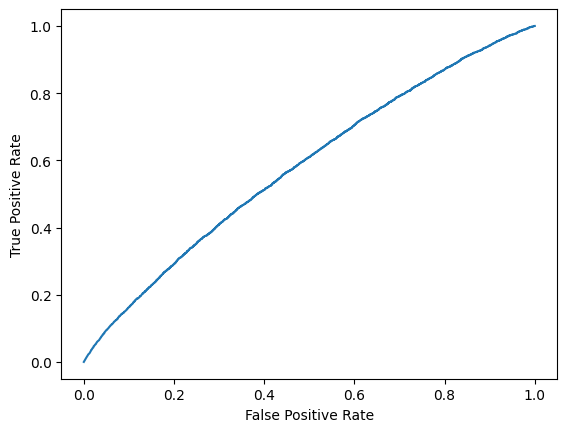

In [57]:
# Plot ROC Curve
predictions = model.predict_proba(df_train[features])[:, 1]
fpr, tpr, _ = roc_curve(df_train['failure'], predictions)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
submission['rank0'] = rankdata(submission['lr0'])

In [51]:
submission['failure'] = submission['rank0']

In [52]:
submission.head()

,id,failure,lr0,rank0
0,26570,7199.0,0.204152,7199.0
1,26571,4342.0,0.199444,4342.0
2,26572,6013.0,0.202289,6013.0
3,26573,5074.0,0.200723,5074.0
4,26574,19959.0,0.241204,19959.0


In [53]:
submission[['id', 'failure']].to_csv('submission.csv', index=False)

In [54]:
filename = 'Model0.sav'
pickle.dump(model, open(filename, 'wb'))